In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scapy.all import rdpcap, ARP
import numpy as np



      timestamp         sender_mac    sender_ip         target_mac  \
0  1.737294e+09  00:ad:24:bf:9d:52  192.168.1.1  00:00:00:00:00:00   
1  1.737294e+09  00:ad:24:bf:9d:52  192.168.1.1  00:00:00:00:00:00   
2  1.737294e+09  00:ad:24:bf:9d:52  192.168.1.1  00:00:00:00:00:00   
3  1.737294e+09  00:ad:24:bf:9d:52  192.168.1.1  00:00:00:00:00:00   
4  1.737294e+09  00:ad:24:bf:9d:52  192.168.1.1  00:00:00:00:00:00   

      target_ip  operation  label  
0  192.168.1.72          1      0  
1  192.168.1.72          1      0  
2  192.168.1.72          1      0  
3  192.168.1.15          1      0  
4  192.168.1.15          1      0  


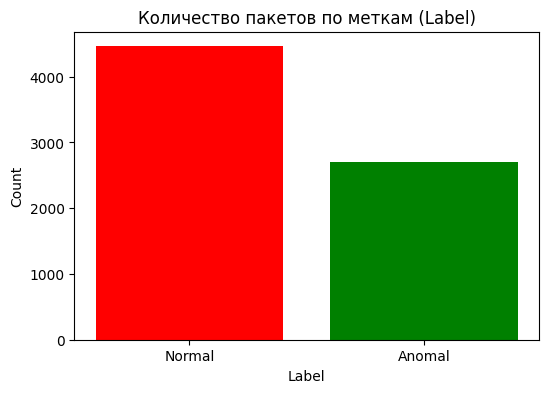

In [5]:

# Объединение нормальных и аномальных данных
df = pd.read_csv(r"D:\Проекты\Дипломаня работа\DoFitN\Code\DoFitN\processed_arp_data_augmented.csv")

# Вывод первых строк
print(df.head())

label_counts = df['label'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, color=['red', 'green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Количество пакетов по меткам (Label)')
plt.xticks([0, 1], ['Normal', 'Anomal'])
plt.show()



In [6]:
df.head(2000)

,timestamp,sender_mac,sender_ip,target_mac,target_ip,operation,label
0,1.737294e+09,00:ad:24:bf:9d:52,192.168.1.1,00:00:00:00:00:00,192.168.1.72,1,0
1,1.737294e+09,00:ad:24:bf:9d:52,192.168.1.1,00:00:00:00:00:00,192.168.1.72,1,0
2,1.737294e+09,00:ad:24:bf:9d:52,192.168.1.1,00:00:00:00:00:00,192.168.1.72,1,0
3,1.737294e+09,00:ad:24:bf:9d:52,192.168.1.1,00:00:00:00:00:00,192.168.1.15,1,0
4,1.737294e+09,00:ad:24:bf:9d:52,192.168.1.1,00:00:00:00:00:00,192.168.1.15,1,0
...,...,...,...,...,...,...,...
1995,1.737297e+09,00:ad:24:bf:9d:52,192.168.1.1,00:00:00:00:00:00,192.168.1.11,1,0
1996,1.737297e+09,00:ad:24:bf:9d:52,192.168.1.1,00:00:00:00:00:00,192.168.1.11,1,0
1997,1.737297e+09,00:ad:24:bf:9d:52,192.168.1.1,00:00:00:00:00:00,192.168.1.11,1,0
1998,1.737297e+09,00:ad:24:bf:9d:52,192.168.1.1,00:00:00:00:00:00,192.168.1.11,1,0


In [9]:
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df[['sender_ip', 'target_ip', 'sender_mac', 'target_mac']])
encoded_columns = encoder.get_feature_names_out(['sender_ip', 'target_ip', 'sender_mac', 'target_mac'])
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns)

# Объединение с основным DataFrame и удаление исходных категориальных признаков
df = pd.concat([df[['operation', 'timestamp', 'label']], encoded_df], axis=1)

In [ ]:
df.head(2000)

,op_type,time_delta,label,src_ip_0.0.0.0,src_ip_192.168.1.1,src_ip_192.168.1.11,src_ip_192.168.1.15,src_ip_192.168.1.31,src_ip_192.168.1.34,src_ip_192.168.1.35,...,src_mac_6e:0d:12:00:ee:72,src_mac_8e:f3:d3:e2:bf:72,src_mac_9c:2f:4e:32:19:52,src_mac_bc:09:eb:12:1d:b3,src_mac_d2:1b:9b:a1:3f:c0,dst_mac_00:00:00:00:00:00,dst_mac_00:ad:24:bf:9d:52,dst_mac_4c:5f:70:98:4d:bf,dst_mac_54:27:1e:9f:2c:b7,dst_mac_9c:2f:4e:32:19:52
0,1,1737294233.933342,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1737294259.323055,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1737294324.446376,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1737294328.956137,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,1737294329.873696,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,1737296555.973773,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1996,1,1737296562.117602,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1997,1,1737296563.141311,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1998,1,1737296564.165249,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model


# Масштабирование данных
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['label']))  # Признаки

# Формирование временных последовательностей
def create_sequences(data, labels, sequence_length):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        sequence_labels.append(labels[i + sequence_length])
    return np.array(sequences), np.array(sequence_labels)

sequence_length = 25 # Длина последовательности
X, y = create_sequences(scaled_features, df['label'].values, sequence_length)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Определение весов для классов
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Автоматическое вычисление весов
    classes=np.unique(y_train),  # Уникальные метки классов
    y=y_train  # Истинные метки обучающей выборки
)

# Преобразование в формат словаря для Keras
class_weights_dict = dict(enumerate(class_weights))

# Печать весов классов для проверки
print(f"Веса классов: {class_weights_dict}")

# Создание модели RNN
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели с указанием весов классов
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test),
                    class_weight=class_weights_dict)

# Оценка модели
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Точность : {accuracy * 100:.2f}%")




Веса классов: {0: np.float64(0.8087378640776699), 1: np.float64(1.309748427672956)}


c:\Users\Slyexistence\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 1:12 923ms/step - accuracy: 0.5938 - loss: 0.71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6930 - loss: 0.6828   ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7689 - loss: 0.644 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8119 - loss: 0.602 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8397 - loss: 0.556 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8586 - loss: 0.514 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8729 - loss: 0.476 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8843 - loss: 0.445 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8934 - loss: 0.418 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9011 - loss: 0.394 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9075 - loss: 0.374 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9129 - loss: 0.357 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9176 - loss: 0.342 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9217 - loss: 0.328 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accur

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Выходной слой

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test),
                    class_weight=class_weights_dict)

 

c:\Users\Slyexistence\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - AUC: 0.6681 - Precision: 0.5862 - Recall: 0.5484 - accuracy: 0.5938 - loss: 0.71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.8555 - Precision: 0.7456 - Recall: 0.7618 - accuracy: 0.7750 - loss: 0.65 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9101 - Precision: 0.8090 - Recall: 0.8230 - accuracy: 0.8390 - loss: 0.61 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9348 - Precision: 0.8450 - Recall: 0.8572 - accuracy: 0.8720 - loss: 0.56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9489 - Precision: 0.8679 - Recall: 0.8791 - accuracy: 0.8927 - loss: 0.51 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9579 - Precision: 0.8841 - Recall: 0.8945 - accuracy: 0.9070 - loss: 0.47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9638 - Precision: 0.8958 - Recall: 0.9058 - accuracy: 0.9172 - loss: 0.44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9682 - Precision: 0.9051 - Recall: 0.9146 - accuracy: 0.9252 - loss: 0.41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9716

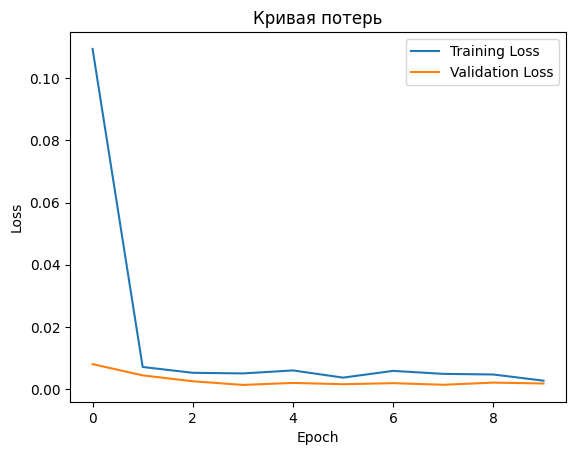

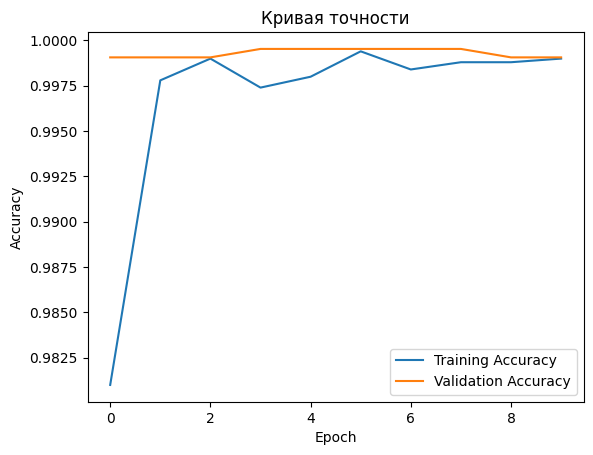

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


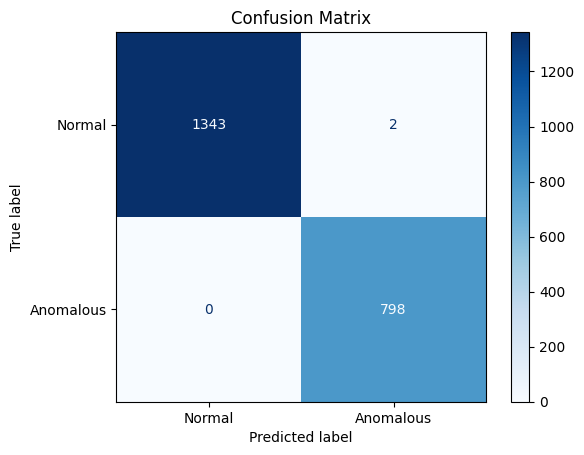

In [27]:
import matplotlib.pyplot as plt

# Построение кривой потерь
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Кривая потерь')
plt.show()

# Кривая точности
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Кривая точности')
plt.show()
# Используем обученную модель для предсказаний на тестовых данных
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Предсказания с порогом 0.5

# Построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)

# Визуализация с использованием ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalous"])
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()

c:\Users\Slyexistence\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
157/157ep - accuracy: 0.9480 - loss: 0.2373148/157y: 0.5312 - loss: 0.6874  2/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5703 - loss: 0.687 ━━━━━━━━━━━━━━━━━━━━ 0 13/157 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7943 - loss: 0.636 ━━━━━━━━━━━━━━━━━━━━  ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8529 - loss: 0.5 38/157━━━━━━━━━━━━━━━━  ━━━━0s━━━━━━━━━━━━━━━━  5ms/step - accuracy: 0.8799 - loss: 0.49 5ms/step - accuracy: 0.8816 - loss: 0.4908 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8832 - loss: 0.48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8995 - loss: 0.43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9007 - loss: 0.42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9122 - loss: 0.38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9130 - loss: 0.38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9208 - loss: 0.35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9214 - loss: 0.34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9276 - loss: 0.32 ━━━━━━

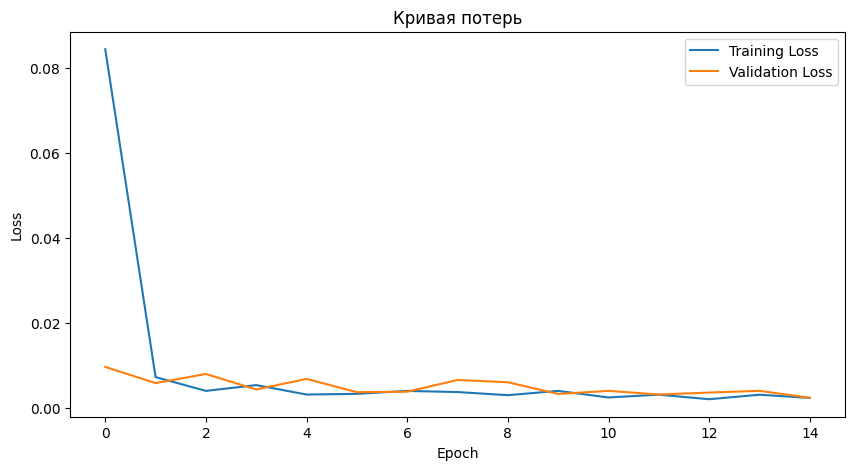

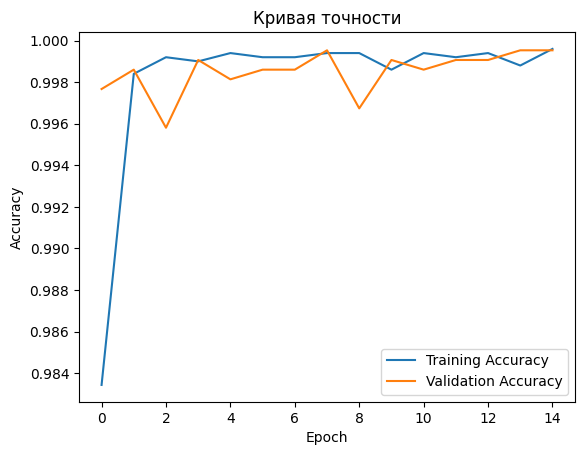

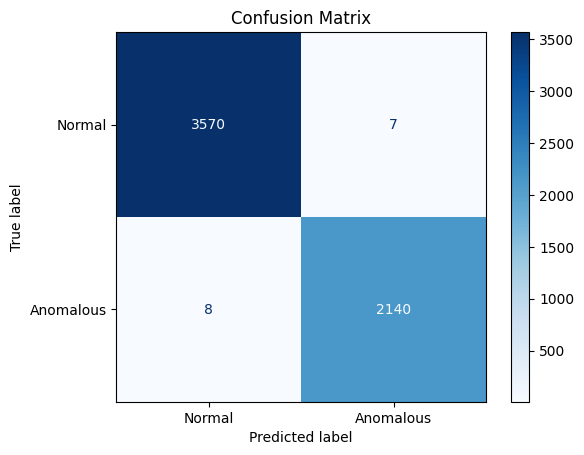

In [13]:
from tensorflow.keras.layers import Dropout

# Масштабирование данных
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['label']))

# Формирование временных последовательностей
def create_sequences(data, labels, sequence_length):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        sequence_labels.append(labels[i+sequence_length])
    return np.array(sequences), np.array(sequence_labels)

sequence_length = 10  # Длина последовательности
X, y = create_sequences(scaled_features, df['label'].values, sequence_length)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Определение весов для классов
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Создание модели RNN с Dropout
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.5))  # Добавляем Dropout для отключения 20% нейронов
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели с указанием весов классов
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights_dict)

# Оценка модели
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Точность: {accuracy * 100:.2f}%")

# Визуализация графиков
plt.figure(figsize=(10,5))

# Построение кривой потерь
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Кривая потерь')
plt.show()

# Кривая точности
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Кривая точности')
plt.show()

# Визуализация с использованием ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalous"])
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()



In [ ]:
import visualkeras
visualkeras.layered_view(model)


c:\Users\Slyexistence\AppData\Local\Programs\Python\Python312\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
